# Feature-Extraction
## Theoretische Grundlagen, Methodik und Umsetzung anhand eines konkreten Beispiels
### KI in der Medizin - Brustkrebs-Datenanalyse 

Wir haben den öffentlich verfügbaren Datensatz Breast Cancer Wisconsin verwendet und vom UCI Machine Learning Repository heruntergeladen. 

Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29


![](./data.png)

In [20]:
# Bibliotheken importieren
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [21]:
# Download des Krebs-Datensatzes 
(X, y) = load_breast_cancer(return_X_y=True, as_frame=True)

In [22]:
# Datensatz in Trainings- und Testdatensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [23]:
# Erstellen und Trainieren eines Autoencoders für die Klassifizierung mit Kompression in der Bottleneck-Schicht.
# Anzahl der Eingangsspalten
n_inputs = X.shape[1]
# Skalierung der Daten
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# Encoder definieren
visible = Input(shape=(n_inputs,))
# Encoder Ebene 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# Encoder Ebene 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# Bottleneck-Schicht
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# Decoder definieren, Ebene 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# Decoder Ebene 1
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# Ausgabe
output = Dense(n_inputs, activation='linear')(d)

![](autoencoder.png)

Epoch 1/50
5/5 - 0s - loss: 0.0014 - val_loss: 0.0018
Epoch 2/50
5/5 - 0s - loss: 0.0013 - val_loss: 0.0016
Epoch 3/50
5/5 - 0s - loss: 0.0013 - val_loss: 0.0015
Epoch 4/50
5/5 - 0s - loss: 0.0011 - val_loss: 0.0014
Epoch 5/50
5/5 - 0s - loss: 0.0013 - val_loss: 0.0015
Epoch 6/50
5/5 - 0s - loss: 0.0011 - val_loss: 0.0013
Epoch 7/50
5/5 - 0s - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
5/5 - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 9/50
5/5 - 0s - loss: 0.0011 - val_loss: 0.0014
Epoch 10/50
5/5 - 0s - loss: 9.9310e-04 - val_loss: 0.0013
Epoch 11/50
5/5 - 0s - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
5/5 - 0s - loss: 0.0011 - val_loss: 0.0013
Epoch 13/50
5/5 - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 14/50
5/5 - 0s - loss: 9.6785e-04 - val_loss: 0.0013
Epoch 15/50
5/5 - 0s - loss: 9.4026e-04 - val_loss: 0.0013
Epoch 16/50
5/5 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 17/50
5/5 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 18/50
5/5 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 1

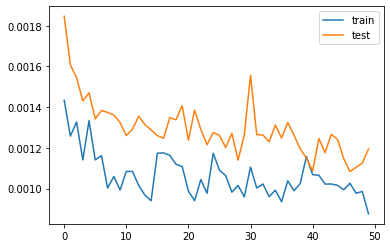

In [33]:
# Autoencoder definieren
model = Model(inputs=visible, outputs=output)
# Kompilieren des Autoencoders
model.compile(optimizer='adam', loss='mse')
# Fit das Autoencoder-Modell, um die Eingabe zu rekonstruieren
history = model.fit(X_train, X_train, epochs=50, batch_size=100, verbose=2, validation_data=(X_test,X_test))
# die Entwicklung der Verlustfunktion darstellen
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# das Encodermodell vom Autoencoder trennen (ohne den Decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# Speichern des Encoders
encoder.save('encoder.h5')

![](encoder.png)

                 precision    recall  f1-score   support

gutartige Tumor       1.00      0.98      0.99        49
bösartige Tumor       0.99      1.00      0.99        94

       accuracy                           0.99       143
      macro avg       0.99      0.99      0.99       143
   weighted avg       0.99      0.99      0.99       143



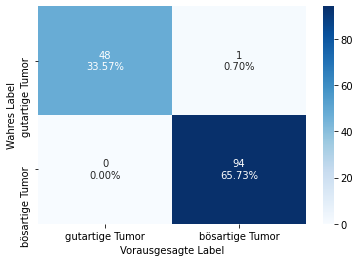

In [34]:
# Baseline in der Performance mit logistischem Regressionsmodell
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix
# Daten Skalierung
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# Einfacher binärer Klassifikator
model = LogisticRegression()
# Modell an Trainingssatz anpassen
model.fit(X_train, y_train)
# Vorhersage für den Testsatz durchführen
yhat = model.predict(X_test)
# Klassifikationsbericht
print(classification_report(y_test, yhat, target_names=['gutartige Tumor','bösartige Tumor']))
make_confusion_matrix(confusion_matrix(y_test, yhat), categories=['gutartige Tumor','bösartige Tumor'])

Accuracy:  0.9671096345514949
Precision:  0.9691869722444434
Recall:  0.9784425451092118
F1:  0.973495918381231 



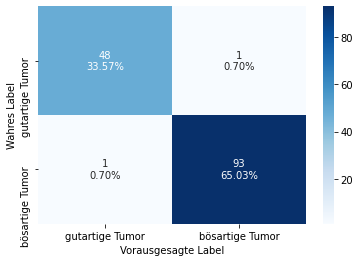

In [39]:
# logistische Regression auf kodierter Eingabe auswerten (Encoder + logistische Regression Klassifikator)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
# Daten Skalierung
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# Laden des Modells aus Datei
encoder = load_model('encoder.h5')
encoder.compile(optimizer='adam', loss='mse')
# die Trainingsdaten kodieren
X_train_encode = encoder.predict(X_train)
# die Testdaten kodieren
X_test_encode = encoder.predict(X_test)
# das Modell definieren
model = LogisticRegression(max_iter=100)
# das Modell an die Trainingsdaten anpassen
model.fit(X_train_encode, y_train)
# Vorhersagen für den Testsatz durchführen
yhat = model.predict(X_test_encode)
# Klassifikationsbericht
print(classification_report(y_test, yhat, target_names=['gutartige Tumor','bösartige Tumor']))
make_confusion_matrix(confusion_matrix(y_test, yhat), categories=['gutartige Tumor','bösartige Tumor'])
#  definieren Sie das Verfahren der Kreuzvalidierung
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Modell auswerten
scores = cross_validate(estimator=model, X=X_train_encode, y=y_train, cv=cv, n_jobs=-1, 
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')

In [36]:
# Klassifizierung auf reduzierter Dimension (PCA-Merkmalsextrahierung + linearer Regressionsklassifikator)
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
# Daten Skalierung
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# Liste der Transformationen an den Daten
transforms = list()
transforms.append(('pca', PCA(n_components=9)))
fu = FeatureUnion(transforms)
# das Modell definieren
model = LogisticRegression(solver='liblinear')
# die Pipeline definieren
steps = list()
steps.append(('fu', fu))
steps.append(('m', model))
pipeline = Pipeline(steps=steps)
#  definieren Sie das Verfahren der Kreuzvalidierung
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Modell auswerten
scores = cross_validate(estimator=pipeline, X=X, y=y, cv=cv, n_jobs=-1, 
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')

Accuracy:  0.9467314118629909
Precision:  0.9509595683357294
Recall:  0.9664021164021164
F1:  0.9579506279305835 



Über diesen Github-Link können Sie auf den gesamten Code und die Daten des Projekts zugreifen.

![](data.png)